In [1]:
from super_gradients.training import models
import cv2
from futstats.annotations.anns import Detection
import matplotlib.pyplot as plt
from super_gradients.training.processing import DetectionCenterPadding, StandardizeImage, NormalizeImage, ImagePermute, ComposeProcessing, DetectionLongestMaxSizeRescale

[2023-12-02 15:50:14] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-12-02 15:50:14] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /home/fer/sg_logs/console.log


[2023-12-02 15:50:16] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-12-02 15:50:16] WARNING - export.py - Failed to import pytorch_quantization
[2023-12-02 15:50:16] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
import torch
print(torch.__version__)
torch.cuda.is_available()

True

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
field = cv2.cvtColor(cv2.imread('../images/field_2d.jpg'), cv2.COLOR_BGR2RGB)


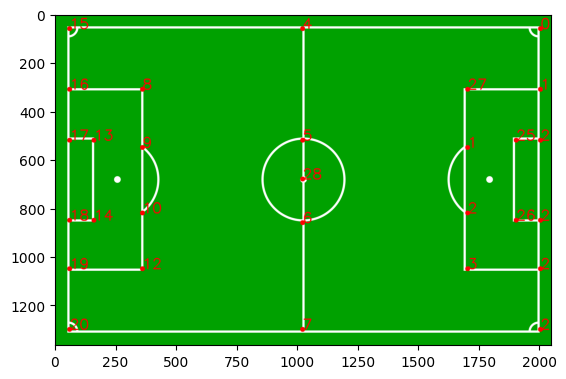

In [8]:
POINT2POINT2D = {
    "0": (2000, 60),
    "1": (1700, 550),
    "2": (1700, 820),
    "3": (1700, 1050),
    "4": (1020, 60),
    "5": (1020, 520),
    "6": (1020, 860),
    "7": (1020, 1300),
    "8": (360, 310),
    "9": (360, 550),
    "10": (360, 820),
    "11": (2000, 310),
    "12": (360, 1050),
    "13": (160, 520),
    "14": (160, 850),
    "15": (60, 60),
    "16": (60, 310),
    "17": (60, 520),
    "18": (60, 850),
    "19": (60, 1050),
    "20": (60, 1300),
    "21": (2000, 520),
    "22": (2000, 850),
    "23": (2000, 1050),
    "24": (2000, 1300),
    "25": (1900, 520),
    "26": (1900, 850),
    "27": (1700, 310),
    "28": (1020, 680),

}

NUM_CLASES = len(POINT2POINT2D)



check = field.copy()

for id_, coord in POINT2POINT2D.items():
    check = cv2.circle(check, coord, 10, (255, 0, 0), -1)
    check = cv2.putText(check, id_, coord, cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0),3)

plt.imshow(check)

In [10]:
# cktp_path =  "./checkpoints/FIELD_KEYPOINTS_COCO_DATA_1/ckpt_best.pth"
cktp_path = "./checkpoints/ckpt_best_nov_new.pth"
cktp_path = "./checkpoints/FIELD_KEYPOINTS_COCO_DATA_3/RUN_20231201_153126_310818/ckpt_best.pth"


model = models.get("yolo_nas_s",
                num_classes=NUM_CLASES,
                checkpoint_path=cktp_path)


# model.set_dataset_processing_params(
#     image_processor = ComposeProcessing(
#     [
#         DetectionLongestMaxSizeRescale(output_shape=(636, 636)),
#         DetectionCenterPadding(output_shape=(640, 640), pad_value=114),
#         StandardizeImage(max_value=255.0),
#         ImagePermute(permutation=(2, 0, 1)),
#     ]
# )
# )

[2023-12-02 15:52:22] INFO - checkpoint_utils.py - Successfully loaded model weights from ./checkpoints/FIELD_KEYPOINTS_COCO_DATA_3/RUN_20231201_153126_310818/ckpt_best.pth EMA checkpoint.


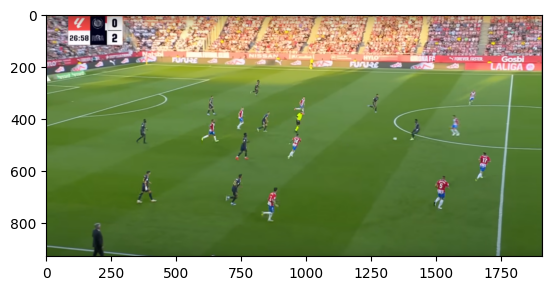

In [11]:
img = cv2.cvtColor(cv2.imread('../images/frame2.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [12]:
results = list(model.predict(img, conf=0.3))[0]
detections = Detection.from_yoloNas(pred=results)
print(len(detections))

[2023-12-02 15:52:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


9


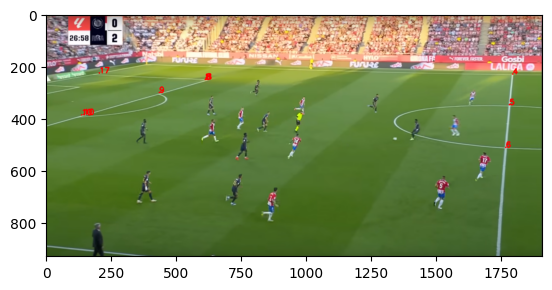

In [13]:

points = img.copy()

for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points = cv2.circle(points, center, 3, (255, 0, 0), -1)
    points = cv2.putText(points, str(detection.class_id), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),3)


plt.imshow(points)

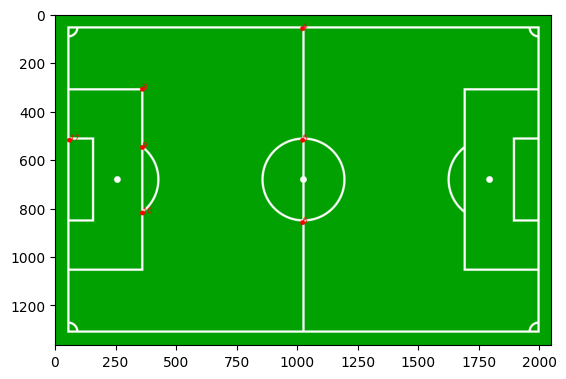

In [14]:
src_points = []
dst_points = []


anns_2d = field.copy()


for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points_2d = POINT2POINT2D[str(detection.class_id)]
    src_points.append(center)
    dst_points.append(points_2d)
    anns_2d = cv2.circle(anns_2d,points_2d, 10, (255, 0, 0), -1)
    anns_2d = cv2.putText(anns_2d, str(detection.class_id), points_2d, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),2)



plt.imshow(anns_2d)

# ball

In [ ]:
import numpy as np
M, _ = cv2.findHomography(np.array(src_points), np.array(dst_points), cv2.RANSAC, 5)


In [ ]:
M

In [ ]:
ball = (100,100)

ball_pt = np.array([ball], np.float32).reshape(-1, 1, 2)
ball_pt_2d = cv2.perspectiveTransform(ball_pt, M)
ball_pt_2d = ball_pt_2d.astype(int)

In [ ]:
ball_pt

# tracking

In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from futstats.tracking.bytrack_utils import (
    BYTETrackerArgs,
    detections2boxes,
    match_detections_with_tracks,
    tracks2boxes
)

In [ ]:
byte_tracker = BYTETracker(BYTETrackerArgs())
field_model = models.get(
    "yolo_nas_s",
    num_classes=29,
    checkpoint_path="/home/fer/Escritorio/futstatistics/futstats/models/ckpt_best_nov_new.pth",
)

In [ ]:
plt.imshow(img)

In [ ]:
tracks = byte_tracker.update(
    output_results=detections2boxes(detections=detections),
    img_info=img.shape,
    img_size=img.shape,
)

In [ ]:
tracks

In [ ]:
tracks2boxes(tracks)

In [ ]:
tracked_detections = match_detections_with_tracks(
    detections=detections, tracks=tracks
)
tracked_detections

In [ ]:
src_points = []
dst_points = []


anns_2d = field.copy()


for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points_2d = POINT2POINT2D[str(detection.class_id)]
    src_points.append(center)
    dst_points.append(points_2d)
    anns_2d = cv2.circle(anns_2d,points_2d, 10, (255, 0, 0), -1)
    anns_2d = cv2.putText(anns_2d, str(detection.class_id), (points_2d[0] + 20,points_2d[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0),2)
    anns_2d = cv2.putText(anns_2d, str(detection.tracker_id), points_2d, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255),2)


plt.imshow(anns_2d)

## KALMAN FILTER

https://machinelearningspace.com/2d-object-tracking-using-kalman-filter/
